In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spelling-mistakes-dataset/mispelled_text.csv
/kaggle/input/zero-width/attacked_text.csv
/kaggle/input/bidi-reordered-dataset/bidi_reordered_attacked.csv
/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv
/kaggle/input/spellcheck-watermarked/corrected_text.csv
/kaggle/input/unnecessary-whitespace-dataset/merged_data.csv


In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 5.52 MiB/s, done.


In [3]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [4]:
import os, sys, argparse, time

import numpy as np
from transformers import AutoTokenizer
from mersenne import mersenne_rng

import pyximport
pyximport.install(reload_support=True, language_level=sys.version_info[0],
                  setup_args={'include_dirs':np.get_include()})
from levenshtein import levenshtein

def permutation_test(tokens,key,n,k,vocab_size,n_runs=100):
    rng = mersenne_rng(key)
    xi = np.array([rng.rand() for _ in range(n*vocab_size)], dtype=np.float32).reshape(n,vocab_size)
    test_result = detect(tokens,n,k,xi)

    p_val = 0
    for run in range(n_runs):
        xi_alternative = np.random.rand(n, vocab_size).astype(np.float32)
        null_result = detect(tokens,n,k,xi_alternative)

        # assuming lower test values indicate presence of watermark
        p_val += null_result <= test_result

    return (p_val+1.0)/(n_runs+1.0)


def detect(tokens,n,k,xi,gamma=0.0):
    m = len(tokens)
    n = len(xi)

    A = np.empty((m-(k-1),n))
    for i in range(m-(k-1)):
        for j in range(n):
            A[i][j] = levenshtein(tokens[i:i+k],xi[(j+np.arange(k))%n],gamma)

    return np.min(A)


In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-cpython-310/kaggle/working/watermark/demo/levenshtein.c:1205:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
from tqdm import tqdm
import pandas as pd
from sklearn.utils import shuffle

def main():
    # Read data from CSV using pandas
    data = pd.read_csv("/kaggle/input/unnecessary-whitespace-dataset/merged_data.csv")

    # Read data from CSV
    data = pd.read_csv("/kaggle/input/unnecessary-whitespace-dataset/merged_data.csv")

    # Sample 100 watermarked and 100 unwatermarked rows
    watermarked_sample = data[data['label'] == 'watermarked'].sample(n=70, random_state=42)
    unwatermarked_sample = data[data['label'] == 'unwatermarked'].sample(n=70, random_state=42)

    # Drop the index for both samples
    watermarked_sample.reset_index(drop=True, inplace=True)
    unwatermarked_sample.reset_index(drop=True, inplace=True)

    # Merge the samples
    merged_samples = pd.concat([watermarked_sample, unwatermarked_sample], ignore_index=True)

    # Shuffle the merged samples
    shuffled_samples = shuffle(merged_samples, random_state=42).reset_index(drop=True)
    shuffled_samples.to_csv("/kaggle/working/Shuffled_samples.csv", index=False)
#     # Combine filtered data
#     split_point1 = int(len(data) / 3)
#     split_point2 = split_point1 * 2
#     split_point3 = 100
#     part1 = shuffled_samples.iloc[:100] # First part
#     part2 = shuffled_samples.iloc[35:69]  # Second part
#     part3 = shuffled_samples.iloc[69:100]  # Third part (might be slightly bigger)
    # Load pre-trained tokenizer (replace with your desired tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    # Progress bar with tqdm
    results = []
    for index, row in tqdm(shuffled_samples.iterrows(), total=len(shuffled_samples)):
        text = row["Modified Text"] 
        actual_label = row['label'] 

        # Tokenize the text
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=2048).numpy()[0]

        t0 = time.time()
        pval = permutation_test(tokens, 42, 256, len(tokens), len(tokenizer))
        label = "watermarked" if pval <= 0.01 else "unwatermarked"
        results.append({"text": text, "p-value": pval, "label": label, "actual_label": actual_label})
        print(f"Row {index+1} - p-value: {pval:.4f}, label: {label}, actual_label {actual_label} (elapsed time: {time.time()-t0:.2f}s)")

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)
#     df_results.head(2)
    # Save the DataFrame (optional)
    df_results.to_csv("permutation_test_results_whitespace.csv", index=False)
if __name__ == '__main__':
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

  1%|          | 1/140 [01:16<2:57:46, 76.74s/it]

Row 1 - p-value: 0.3564, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.71s)


  1%|▏         | 2/140 [04:50<6:01:38, 157.23s/it]

Row 2 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 213.58s)


  2%|▏         | 3/140 [08:13<6:46:51, 178.19s/it]

Row 3 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 203.11s)


  3%|▎         | 4/140 [09:12<4:57:01, 131.04s/it]

Row 4 - p-value: 0.1287, label: unwatermarked, actual_label unwatermarked (elapsed time: 58.76s)


  4%|▎         | 5/140 [12:28<5:47:47, 154.57s/it]

Row 5 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 196.30s)


  4%|▍         | 6/140 [15:50<6:21:24, 170.78s/it]

Row 6 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 202.23s)


  5%|▌         | 7/140 [17:06<5:10:01, 139.86s/it]

Row 7 - p-value: 0.4257, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.20s)


  6%|▌         | 8/140 [20:01<5:31:49, 150.83s/it]

Row 8 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 174.32s)


  6%|▋         | 9/140 [21:18<4:38:50, 127.71s/it]

Row 9 - p-value: 0.9208, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.88s)


  7%|▋         | 10/140 [22:35<4:02:42, 112.02s/it]

Row 10 - p-value: 0.8713, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.88s)


  8%|▊         | 11/140 [23:52<3:38:00, 101.40s/it]

Row 11 - p-value: 0.4059, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.32s)


  9%|▊         | 12/140 [28:11<5:18:27, 149.27s/it]

Row 12 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 258.77s)


  9%|▉         | 13/140 [31:18<5:40:36, 160.92s/it]

Row 13 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 187.71s)


 10%|█         | 14/140 [34:38<6:02:42, 172.71s/it]

Row 14 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 199.97s)


 11%|█         | 15/140 [35:55<4:59:21, 143.69s/it]

Row 15 - p-value: 1.0000, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.42s)


 11%|█▏        | 16/140 [37:11<4:15:17, 123.53s/it]

Row 16 - p-value: 0.0693, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.70s)


 12%|█▏        | 17/140 [40:52<5:12:57, 152.67s/it]

Row 17 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 220.43s)


 13%|█▎        | 18/140 [44:29<5:49:34, 171.93s/it]

Row 18 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 216.76s)


 14%|█▎        | 19/140 [45:45<4:48:57, 143.28s/it]

Row 19 - p-value: 0.8119, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.56s)


 14%|█▍        | 20/140 [47:02<4:06:35, 123.29s/it]

Row 20 - p-value: 0.9802, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.70s)


 15%|█▌        | 21/140 [49:50<4:31:15, 136.77s/it]

Row 21 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 168.18s)


 16%|█▌        | 22/140 [51:07<3:53:25, 118.69s/it]

Row 22 - p-value: 0.1584, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.52s)


 16%|█▋        | 23/140 [54:27<4:39:07, 143.14s/it]

Row 23 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 200.16s)


 17%|█▋        | 24/140 [57:18<4:53:10, 151.64s/it]

Row 24 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 171.49s)


 18%|█▊        | 25/140 [58:35<4:07:37, 129.20s/it]

Row 25 - p-value: 0.1287, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.84s)


 19%|█▊        | 26/140 [1:03:20<5:34:06, 175.84s/it]

Row 26 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 284.66s)


 19%|█▉        | 27/140 [1:04:37<4:35:20, 146.20s/it]

Row 27 - p-value: 0.4752, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.03s)


 20%|██        | 28/140 [1:05:42<3:47:43, 122.00s/it]

Row 28 - p-value: 0.5248, label: unwatermarked, actual_label unwatermarked (elapsed time: 65.52s)


 21%|██        | 29/140 [1:08:41<4:17:00, 138.92s/it]

Row 29 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 178.42s)


 21%|██▏       | 30/140 [1:12:05<4:50:24, 158.40s/it]

Row 30 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 203.85s)


 22%|██▏       | 31/140 [1:14:50<4:51:29, 160.45s/it]

Row 31 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 165.23s)


 23%|██▎       | 32/140 [1:16:07<4:03:57, 135.53s/it]

Row 32 - p-value: 0.7921, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.39s)


 24%|██▎       | 33/140 [1:17:24<3:30:04, 117.80s/it]

Row 33 - p-value: 0.0495, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.43s)


 24%|██▍       | 34/140 [1:18:41<3:06:31, 105.58s/it]

Row 34 - p-value: 0.1980, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.06s)


 25%|██▌       | 35/140 [1:21:51<3:49:30, 131.15s/it]

Row 35 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 190.80s)


 26%|██▌       | 36/140 [1:24:56<4:14:51, 147.03s/it]

Row 36 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 184.10s)


 26%|██▋       | 37/140 [1:26:10<3:35:12, 125.36s/it]

Row 37 - p-value: 0.6634, label: unwatermarked, actual_label unwatermarked (elapsed time: 74.78s)


 27%|██▋       | 38/140 [1:27:27<3:08:18, 110.77s/it]

Row 38 - p-value: 0.1089, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.72s)


 28%|██▊       | 39/140 [1:30:51<3:53:27, 138.69s/it]

Row 39 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 203.84s)


 29%|██▊       | 40/140 [1:34:25<4:28:39, 161.19s/it]

Row 40 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 213.70s)


 29%|██▉       | 41/140 [1:38:00<4:52:39, 177.37s/it]

Row 41 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 215.10s)


 30%|███       | 42/140 [1:40:52<4:47:16, 175.89s/it]

Row 42 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 172.43s)


 31%|███       | 43/140 [1:43:57<4:48:49, 178.66s/it]

Row 43 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 185.12s)


 31%|███▏      | 44/140 [1:46:47<4:41:35, 175.99s/it]

Row 44 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 169.78s)


 32%|███▏      | 45/140 [1:48:04<3:51:40, 146.32s/it]

Row 45 - p-value: 0.3564, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.09s)


 33%|███▎      | 46/140 [1:49:23<3:17:35, 126.12s/it]

Row 46 - p-value: 0.6634, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.98s)


 34%|███▎      | 47/140 [1:50:40<2:52:25, 111.24s/it]

Row 47 - p-value: 0.0693, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.50s)


 34%|███▍      | 48/140 [1:53:55<3:29:25, 136.58s/it]

Row 48 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 195.72s)


 35%|███▌      | 49/140 [1:57:22<3:59:04, 157.63s/it]

Row 49 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 206.73s)


 36%|███▌      | 50/140 [2:00:24<4:07:10, 164.78s/it]

Row 50 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 181.47s)


 36%|███▋      | 51/140 [2:01:27<3:19:19, 134.38s/it]

Row 51 - p-value: 0.5941, label: unwatermarked, actual_label unwatermarked (elapsed time: 63.44s)


 37%|███▋      | 52/140 [2:04:48<3:46:18, 154.30s/it]

Row 52 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 200.79s)


 38%|███▊      | 53/140 [2:08:01<4:00:36, 165.93s/it]

Row 53 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 193.06s)


 39%|███▊      | 54/140 [2:09:18<3:19:32, 139.21s/it]

Row 54 - p-value: 0.8713, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.86s)


 39%|███▉      | 55/140 [2:10:35<2:50:55, 120.65s/it]

Row 55 - p-value: 0.4059, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.34s)


 40%|████      | 56/140 [2:11:52<2:30:30, 107.50s/it]

Row 56 - p-value: 0.4950, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.81s)


 41%|████      | 57/140 [2:15:08<3:05:15, 133.92s/it]

Row 57 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 195.57s)


 41%|████▏     | 58/140 [2:18:29<3:30:47, 154.24s/it]

Row 58 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 201.63s)


 42%|████▏     | 59/140 [2:19:46<2:56:45, 130.93s/it]

Row 59 - p-value: 0.7921, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.56s)


 43%|████▎     | 60/140 [2:21:03<2:33:07, 114.84s/it]

Row 60 - p-value: 0.7723, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.28s)


 44%|████▎     | 61/140 [2:24:31<3:08:07, 142.88s/it]

Row 61 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 208.31s)


 44%|████▍     | 62/140 [2:28:08<3:34:37, 165.10s/it]

Row 62 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 216.95s)


 45%|████▌     | 63/140 [2:29:25<2:58:01, 138.72s/it]

Row 63 - p-value: 0.7822, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.18s)


 46%|████▌     | 64/140 [2:32:38<3:16:10, 154.88s/it]

Row 64 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 192.57s)


 46%|████▋     | 65/140 [2:33:55<2:44:29, 131.59s/it]

Row 65 - p-value: 0.3366, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.24s)


 47%|████▋     | 66/140 [2:37:02<3:02:47, 148.21s/it]

Row 66 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 186.98s)


 48%|████▊     | 67/140 [2:40:09<3:14:14, 159.65s/it]

Row 67 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 186.34s)


 49%|████▊     | 68/140 [2:41:25<2:41:36, 134.68s/it]

Row 68 - p-value: 0.5446, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.40s)


 49%|████▉     | 69/140 [2:44:13<2:51:15, 144.73s/it]

Row 69 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 168.18s)


 50%|█████     | 70/140 [2:46:52<2:53:56, 149.09s/it]

Row 70 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 159.26s)


 51%|█████     | 71/140 [2:48:09<2:26:23, 127.29s/it]

Row 71 - p-value: 0.6436, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.43s)


 51%|█████▏    | 72/140 [2:49:25<2:07:00, 112.06s/it]

Row 72 - p-value: 0.6238, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.53s)


 52%|█████▏    | 73/140 [2:52:29<2:29:07, 133.55s/it]

Row 73 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 183.67s)


 53%|█████▎    | 74/140 [2:55:33<2:43:40, 148.80s/it]

Row 74 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 184.40s)


 54%|█████▎    | 75/140 [2:58:28<2:49:25, 156.39s/it]

Row 75 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 174.10s)


 54%|█████▍    | 76/140 [2:59:44<2:21:15, 132.43s/it]

Row 76 - p-value: 0.8119, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.53s)


 55%|█████▌    | 77/140 [3:02:24<2:27:44, 140.71s/it]

Row 77 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 160.03s)


 56%|█████▌    | 78/140 [3:05:40<2:42:24, 157.18s/it]

Row 78 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 195.59s)


 56%|█████▋    | 79/140 [3:06:56<2:15:03, 132.84s/it]

Row 79 - p-value: 0.1980, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.06s)


 57%|█████▋    | 80/140 [3:08:12<1:56:00, 116.00s/it]

Row 80 - p-value: 0.1683, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.71s)


 58%|█████▊    | 81/140 [3:09:29<1:42:20, 104.07s/it]

Row 81 - p-value: 0.1683, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.23s)


 59%|█████▊    | 82/140 [3:10:45<1:32:35, 95.79s/it] 

Row 82 - p-value: 0.0198, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.45s)


 59%|█████▉    | 83/140 [3:13:53<1:57:18, 123.48s/it]

Row 83 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 188.10s)


 60%|██████    | 84/140 [3:17:13<2:16:41, 146.46s/it]

Row 84 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 200.08s)


 61%|██████    | 85/140 [3:18:30<1:55:06, 125.57s/it]

Row 85 - p-value: 0.1386, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.81s)


 61%|██████▏   | 86/140 [3:21:14<2:03:24, 137.11s/it]

Row 86 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 164.05s)


 62%|██████▏   | 87/140 [3:24:54<2:23:06, 162.01s/it]

Row 87 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 220.09s)


 63%|██████▎   | 88/140 [3:28:28<2:33:48, 177.48s/it]

Row 88 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 213.56s)


 64%|██████▎   | 89/140 [3:29:46<2:05:37, 147.80s/it]

Row 89 - p-value: 0.9703, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.54s)


 64%|██████▍   | 90/140 [3:31:05<1:45:45, 126.91s/it]

Row 90 - p-value: 0.0990, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.17s)


 65%|██████▌   | 91/140 [3:34:42<2:05:55, 154.18s/it]

Row 91 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 217.82s)


 66%|██████▌   | 92/140 [3:36:00<1:44:53, 131.12s/it]

Row 92 - p-value: 0.2079, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.29s)


 66%|██████▋   | 93/140 [3:37:17<1:30:02, 114.95s/it]

Row 93 - p-value: 0.8119, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.23s)


 67%|██████▋   | 94/140 [3:38:32<1:18:56, 102.96s/it]

Row 94 - p-value: 0.3465, label: unwatermarked, actual_label unwatermarked (elapsed time: 74.98s)


 68%|██████▊   | 95/140 [3:43:08<1:56:05, 154.80s/it]

Row 95 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 275.75s)


 69%|██████▊   | 96/140 [3:46:03<1:58:01, 160.93s/it]

Row 96 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 175.24s)


 69%|██████▉   | 97/140 [3:47:10<1:35:12, 132.84s/it]

Row 97 - p-value: 0.8218, label: unwatermarked, actual_label unwatermarked (elapsed time: 67.28s)


 70%|███████   | 98/140 [3:50:36<1:48:19, 154.75s/it]

Row 98 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 205.88s)


 71%|███████   | 99/140 [3:51:55<1:30:06, 131.88s/it]

Row 99 - p-value: 0.2673, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.50s)


 71%|███████▏  | 100/140 [3:54:34<1:33:30, 140.27s/it]

Row 100 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 159.85s)


 72%|███████▏  | 101/140 [3:55:51<1:18:50, 121.28s/it]

Row 101 - p-value: 0.8713, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.98s)


 73%|███████▎  | 102/140 [3:57:10<1:08:39, 108.40s/it]

Row 102 - p-value: 0.6436, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.33s)


 74%|███████▎  | 103/140 [3:58:27<1:01:04, 99.04s/it] 

Row 103 - p-value: 0.9208, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.21s)


 74%|███████▍  | 104/140 [3:59:44<55:29, 92.50s/it]  

Row 104 - p-value: 0.4851, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.23s)


 75%|███████▌  | 105/140 [4:02:40<1:08:28, 117.39s/it]

Row 105 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 175.48s)


 76%|███████▌  | 106/140 [4:06:05<1:21:23, 143.62s/it]

Row 106 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 204.82s)


 76%|███████▋  | 107/140 [4:07:22<1:08:01, 123.69s/it]

Row 107 - p-value: 0.5149, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.17s)


 77%|███████▋  | 108/140 [4:10:48<1:19:06, 148.33s/it]

Row 108 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 205.81s)


 78%|███████▊  | 109/140 [4:12:06<1:05:44, 127.23s/it]

Row 109 - p-value: 0.9307, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.02s)


 79%|███████▊  | 110/140 [4:13:22<56:04, 112.15s/it]  

Row 110 - p-value: 0.2277, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.94s)


 79%|███████▉  | 111/140 [4:14:40<49:09, 101.71s/it]

Row 111 - p-value: 0.2178, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.34s)


 80%|████████  | 112/140 [4:19:05<1:10:17, 150.61s/it]

Row 112 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 264.72s)


 81%|████████  | 113/140 [4:20:17<57:14, 127.19s/it]  

Row 113 - p-value: 0.6139, label: unwatermarked, actual_label unwatermarked (elapsed time: 72.54s)


 81%|████████▏ | 114/140 [4:23:32<1:03:58, 147.63s/it]

Row 114 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 195.32s)


 82%|████████▏ | 115/140 [4:24:50<52:43, 126.53s/it]  

Row 115 - p-value: 0.2376, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.30s)


 83%|████████▎ | 116/140 [4:27:48<56:47, 141.98s/it]

Row 116 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 178.02s)


 84%|████████▎ | 117/140 [4:31:02<1:00:25, 157.65s/it]

Row 117 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 194.21s)


 84%|████████▍ | 118/140 [4:32:19<48:54, 133.39s/it]  

Row 118 - p-value: 0.0396, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.80s)


 85%|████████▌ | 119/140 [4:36:42<1:00:20, 172.41s/it]

Row 119 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 263.45s)


 86%|████████▌ | 120/140 [4:40:07<1:00:39, 181.99s/it]

Row 120 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 204.35s)


 86%|████████▋ | 121/140 [4:41:23<47:36, 150.34s/it]  

Row 121 - p-value: 0.9406, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.49s)


 87%|████████▋ | 122/140 [4:42:40<38:29, 128.33s/it]

Row 122 - p-value: 0.1089, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.97s)


 88%|████████▊ | 123/140 [4:47:10<48:26, 170.97s/it]

Row 123 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 270.45s)


 89%|████████▊ | 124/140 [4:50:33<48:08, 180.55s/it]

Row 124 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 202.91s)


 89%|████████▉ | 125/140 [4:53:40<45:37, 182.47s/it]

Row 125 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 186.95s)


 90%|█████████ | 126/140 [4:56:46<42:47, 183.42s/it]

Row 126 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 185.62s)


 91%|█████████ | 127/140 [4:59:38<39:00, 180.06s/it]

Row 127 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 172.24s)


 91%|█████████▏| 128/140 [5:00:55<29:48, 149.04s/it]

Row 128 - p-value: 0.3861, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.64s)


 92%|█████████▏| 129/140 [5:02:12<23:22, 127.49s/it]

Row 129 - p-value: 0.1881, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.20s)


 93%|█████████▎| 130/140 [5:03:29<18:43, 112.36s/it]

Row 130 - p-value: 0.8020, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.08s)


 94%|█████████▎| 131/140 [5:04:46<15:15, 101.75s/it]

Row 131 - p-value: 0.1089, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.98s)


 94%|█████████▍| 132/140 [5:06:03<12:34, 94.27s/it] 

Row 132 - p-value: 0.7921, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.80s)


 95%|█████████▌| 133/140 [5:07:13<10:08, 86.99s/it]

Row 133 - p-value: 0.2970, label: unwatermarked, actual_label unwatermarked (elapsed time: 70.01s)


 96%|█████████▌| 134/140 [5:08:29<08:23, 83.84s/it]

Row 134 - p-value: 0.2079, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.48s)


 96%|█████████▋| 135/140 [5:11:20<09:09, 109.85s/it]

Row 135 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 170.55s)


 97%|█████████▋| 136/140 [5:12:37<06:40, 100.02s/it]

Row 136 - p-value: 0.9307, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.07s)


 98%|█████████▊| 137/140 [5:13:54<04:39, 93.17s/it] 

Row 137 - p-value: 0.3861, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.18s)


 99%|█████████▊| 138/140 [5:16:47<03:54, 117.16s/it]

Row 138 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 173.15s)


 99%|█████████▉| 139/140 [5:17:56<01:42, 102.50s/it]

Row 139 - p-value: 0.3861, label: unwatermarked, actual_label unwatermarked (elapsed time: 68.30s)


100%|██████████| 140/140 [5:19:12<00:00, 136.81s/it]

Row 140 - p-value: 0.0297, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.81s)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

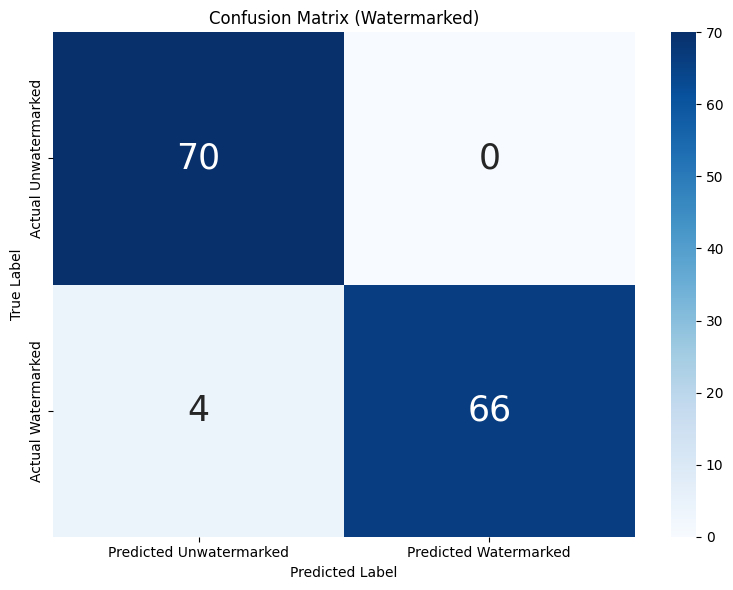


Classification Metrics:
Accuracy: 97.1429
F1-score: 97.1405
Precision: 97.2973
Recall: 97.1429


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['actual_label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
      # Define custom labels for the confusion matrix

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Watermarked)')
    plt.xticks([0.5, 1.5], ['Predicted Unwatermarked', 'Predicted Watermarked'])
    plt.yticks([0.5, 1.5], ['Actual Unwatermarked', 'Actual Watermarked'])    
    plt.tight_layout()
    plt.show()
    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/watermark/demo/permutation_test_results_whitespace.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")


In [8]:
def evaluate_misclassifications(file_path):
    # Evaluates the average absolute difference between misclassified p-values and the threshold (0.1) for watermarked images.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for misclassified watermarked images
    misclassified_watermarked = df[(df['label'] != df['actual_label']) & (df['actual_label'] == 'watermarked')]

    # Check if there are any misclassified watermarked images
    if len(misclassified_watermarked) == 0:
        print("No misclassified watermarked images found.")
        return None

    # Calculate absolute difference between misclassified p-values and the threshold (0.1)
    abs_diff = np.abs(misclassified_watermarked['p-value'] - 0.1)

    # Calculate average absolute difference
    average_diff = np.mean(abs_diff)

    return average_diff

# Specify the file path
file_path = "/kaggle/working/watermark/demo/permutation_test_results_whitespace.csv"

# Evaluate misclassifications
average_diff = evaluate_misclassifications(file_path)

if average_diff is not None:
    print(f"Average absolute difference for misclassified watermarked images: {average_diff:.4f}")


Average absolute difference for misclassified watermarked images: 0.0802


In [9]:
def get_incorrect_samples(file_path):
   
    # Extracts all samples from a CSV file where 'label' and 'actual_label' differ.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for rows where label doesn't equal actual_label
    incorrect_samples = df[df['label'] != df['actual_label']]
    incorrect_samples = incorrect_samples.sort_values(by='actual_label')

    return incorrect_samples

file_path = "/kaggle/working/watermark/demo/permutation_test_results_whitespace.csv"
incorrect_df = get_incorrect_samples(file_path)


incorrect_df.head(len(incorrect_df))

,text,p-value,label,actual_label
38,It was to honour the women who die of c...,0.019802,unwatermarked,watermarked
42,The army has ensured that the environm...,0.019802,unwatermarked,watermarked
49,Anyone is capable of winning an electio...,0.019802,unwatermarked,watermarked
68,The system\thas helped\tto increase produc...,0.019802,unwatermarked,watermarked
